In [1]:
# General imports
import numpy as np
import re
import sympy as sp
import json

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize, differential_evolution, basinhopping

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [2]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [3]:
# Function to calculate the Hamiltonian
def calculate_Hamiltonian(cut_off):
    # Generate the position (q) and momentum (p) matrices
    q = create_matrix(cut_off, 'q')  # q matrix
    p = create_matrix(cut_off, 'p')  # p matrix
    
    #fermionic identity
    I_f = np.eye(2)

    # Calculate q^2 and q^3 for potential terms
    q2 = np.dot(q, q)
    q3 = np.dot(q2, q)
    
    # Superpotential derivatives
    W_prime = q + q3  # W'(q) = q + q^3
    W_double_prime = np.eye(cut_off) + 3 * q2  # W''(q) = 1 + 3q^2

    # Kinetic term: p^2
    p2 = np.dot(p, p)

    # Commutator term [b^†, b] = -Z
    Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
    commutator_term = np.kron(Z, W_double_prime)

    # Construct the block-diagonal kinetic term (bosonic and fermionic parts)
    # Bosonic part is the same for both, hence we use kron with the identity matrix
    kinetic_term = np.kron(I_f, p2)

    # Potential term (W' contribution)
    potential_term = np.kron(I_f, np.dot(W_prime, W_prime))

    # Construct the full Hamiltonian
    H_SQM = 0.5 * (kinetic_term + potential_term + commutator_term)

    return H_SQM

In [4]:
H = calculate_Hamiltonian(16)

In [5]:
sympy_matrix = sp.Matrix(H)
sp.pprint(sympy_matrix, use_unicode=True)

⎡     3.4375              0          7.15945615951379         0          5.817 ↪
⎢                                                                              ↪
⎢       0              14.5625              0          24.0356181010599        ↪
⎢                                                                              ↪
⎢7.15945615951379         0              39.9375              0          56.94 ↪
⎢                                                                              ↪
⎢       0          24.0356181010599         0              87.0625             ↪
⎢                                                                              ↪
⎢5.81753813911005         0          56.9411702988268         0              1 ↪
⎢                                                                              ↪
⎢       0          17.1163299220364         0          111.523890377802        ↪
⎢                                                                              ↪
⎢1.67705098312484         0 

In [6]:
hamiltonian = SparsePauliOp.from_operator(H)
#hamiltonian = SparsePauliOp.from_list([('III',2), ('IIZ',0.5), ('IZI', -1), ('ZZI',-0.5)])
#ansatz = EfficientSU2(hamiltonian.num_qubits)
#ansatz = TwoLocal(hamiltonian.num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [7]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [8]:
num_params = ansatz.num_parameters
x0 = 0.0025* np.pi * np.random.random(num_params)

In [9]:
minima = []

def callback(x, f, accept):
    info = [x,f,accept]
    minima.append(info)
    return

In [10]:
energies = []
x_values = []

for i in range(100):

    print("####################")
    print(f"Session loop {i}")

    with Session(backend=aer_sim) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 10000
        #estimator.options.optimization_level = 1

        res = basinhopping(
            cost_func,
            x0,
            minimizer_kwargs={'method': "COBYLA",
                            "args": (ansatz_isa, hamiltonian_isa, estimator),
                            "options": {'maxiter':1000}},
                            #"tol": '0.00001'},
            niter = 3,
            T = 0.25
            #callback=callback
        )
        energies.append(res.fun)
        x_values.append(res.x)

####################
Session loop 0
Iters. done: 1 [Current cost: 27.633533393858702]
Iters. done: 2 [Current cost: 50.634321909475645]
Iters. done: 3 [Current cost: 100.32957821012894]
Iters. done: 4 [Current cost: 628.8796056902377]
Iters. done: 5 [Current cost: 207.0897699719514]
Iters. done: 6 [Current cost: 19.55042773346656]
Iters. done: 7 [Current cost: 10.440641441030673]
Iters. done: 8 [Current cost: 9.018540718140722]
Iters. done: 9 [Current cost: 157.04534099439618]
Iters. done: 10 [Current cost: 482.84306969908783]
Iters. done: 11 [Current cost: 32.32043044779554]
Iters. done: 12 [Current cost: 1159.3924916439084]
Iters. done: 13 [Current cost: 257.714584156336]
Iters. done: 14 [Current cost: 25.826710115971103]
Iters. done: 15 [Current cost: 132.6592397405704]
Iters. done: 16 [Current cost: 18.35478409384524]
Iters. done: 17 [Current cost: 15.64580140327456]
Iters. done: 18 [Current cost: 18.58847808445476]
Iters. done: 19 [Current cost: 348.34544788446374]
Iters. done: 20

In [98]:
energies

[-0.8409117140010728,
 -9.981678960043329,
 -30.857256991685347,
 -7.73995154618288,
 15.239379235761291,
 -16.996318549021698,
 1.9543861949759964,
 3.1595235254763416,
 26.23728651427518,
 9.943415419963854,
 -6.782919583689971,
 0.8904810053325742,
 -0.4350959233322005,
 -3.991730111899443,
 10.362469249660839,
 -2.2576886651318926]

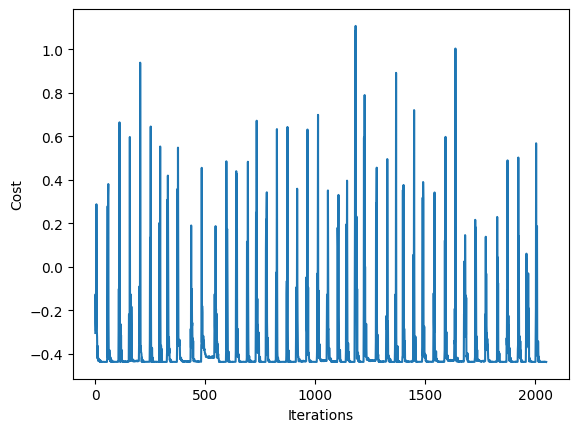

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [11]:
run = {
    'potential': 'AHO',
    'cutoff': 16,
    'ansatz': 'RealAmplitudes',
    'num_sessions': 100,
    'backend': 'aer_simulator',
    'estimator_shots': 10000,
    'min_function': {'name': 'basinhopping',
                     'args': {'minimizer_kwargs': {'method': "COBYLA",
                                                    "args": ('ansatz_isa', 'hamiltonian_isa', 'estimator'),
                                                    "options": {'maxiter':1000}},   
                                'niter': 3,
                                'T': 0.25}
                    },
    'results': energies,
    'x_values': [x.tolist() for x in x_values]
}

In [12]:
path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_16.json"
# Save the variable to a JSON file
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [13]:
n_values = [2, 4, 8, 16]
data_dict = {}

base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_{}.json"

for n in n_values:
    file_path = base_path.format(n)
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)

In [14]:
for c in data_dict.keys():
    res = [x for x in data_dict[c]['results']]
    print(c)
    print("Min: ", min(res))
    print("Avg: ", np.mean(res))

c2
Min:  -0.4375
Avg:  -0.4374975
c4
Min:  -0.24108233132392165
Avg:  -0.1333196277260035
c8
Min:  -0.8417416284745765
Avg:  1.6553677447548585
c16
Min:  -28.926533464003278
Avg:  3.549705413130431
